# Test 4 - Comparison vs FM paper: CoinCollector, CookingGame, TreasureHunter

In [39]:
! tar czf Testing.tar *

In [1]:
! nvidia-smi

Fri Sep 19 13:19:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
|  0%   50C    P8             21W /  450W |      41MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pickle
import random

In [3]:
import sys
sys.path.append("../Self-evaluation")

from self_evaluation import play, LLMAgentSelfEvaluate

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Game generation

Idea:
- two models used: no-think and 10-think
- different difficulty levels: 6 for coin collector, ~5 for common sense,~ 5 for cooking, 8 for treasure hunter
- 5 seeds per case (vs 40 in FM paper), 1 episode per seed
- total episodes: 240 (190 without commonsense)

In [22]:
levels = {"coin_collector": 14, "cooking": 5, "treasure_hunter": 29}
seeds = range(1,11)

In [ ]:
import subprocess

for game in levels.keys():
    if game == "cooking":
        continue # we generate cooking in another way
    for level in range(1, levels[game]+1):
        for seed in seeds:
            subprocess.run(["tw-make", f"tw-{game}", "--level", f"{level}", "--seed", f"{seed}", "--output", f"games/{game}/level{level}-seed{seed}.z8"]) 

In [18]:
# redo coin collector level 8 with more seeds
for seed in seeds:
    subprocess.run(["tw-make", "tw-coin_collector", "--level", "8", "--seed", f"{seed}", "--output", f"games/coin_collector/level8-seed{seed}.z8"])

# play immediately
for n in n_think_indices:
    results_all_seeds = []
    for seed in seeds:
        results = play(LLMAgentSelfEvaluate(selfeval_turns=n, verbose=False),
                f"games/coin_collector/level8-seed{seed}.z8", max_steps=max_steps, n_episodes=n_episodes)
        results_all_seeds.append(results[0]) # only one episode
    with open(f"./Testing 4/{n}think_coin_collector_level8", "wb") as f:
        pickle.dump(results_all_seeds, f)
        print("Data pickled.")
        f.close()

Global seed: 1
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/coin_collector/level8-seed1.z8
Global seed: 2
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/coin_collector/level8-seed2.z8
Global seed: 3
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/coin_collector/level8-seed3.z8
Global seed: 4
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/coin_collector/level8-seed4.z8
Global seed: 5
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/coin_collector/level8-seed5.z8
Global seed: 6
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/coin_collector/level8-seed6.z8
Global seed: 7
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/coin_collector/level8-seed7.z8
Global seed: 8
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/coin_collector/level8-seed8.z8
Global seed: 9
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/coin_collector/level8-seed9.z8
Global see

In [29]:
# treasure hunter levels 16-30

import subprocess

for game in levels.keys():
    if game == "cooking" or game == "coin_collector":
        continue # we generate in another way
    for level in range(16, 30):
        for seed in seeds:
            subprocess.run(["tw-make", f"tw-{game}", "--level", f"{level}", "--seed", f"{seed}", "--output", f"games/{game}/level{level}-seed{seed}.z8"]) 

Global seed: 1
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level16-seed1.z8
Global seed: 2
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level16-seed2.z8
Global seed: 3
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level16-seed3.z8
Global seed: 4
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level16-seed4.z8
Global seed: 5
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level16-seed5.z8
Global seed: 6
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level16-seed6.z8
Global seed: 7
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level16-seed7.z8
Global seed: 8
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level16-seed8.z8
Global seed: 9
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level16-s

Traceback (most recent call last):
  File "/usr/local/bin/tw-make", line 214, in <module>
    game = make_game(settings=args.__dict__, options=options)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/textworld/challenges/tw_treasure_hunter/treasure_hunter.py", line 119, in make
    return make_game(mode, options)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/textworld/challenges/tw_treasure_hunter/treasure_hunter.py", line 228, in make_game
    raise QuestGenerationError(msg.format(options.quest_length))
textworld.generator.chaining.QuestGenerationError: Current map configuration doesn't permit quest of length: 10.Try using a different value for the `--seed` argument.


Global seed: 4
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level20-seed4.z8
Global seed: 5
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level20-seed5.z8
Global seed: 6
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level20-seed6.z8
Global seed: 7
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level20-seed7.z8
Global seed: 8
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level20-seed8.z8
Global seed: 9
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level20-seed9.z8
Global seed: 10
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level20-seed10.z8
Global seed: 1
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level21-seed1.z8
Global seed: 2
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level21

In [30]:
!tw-make tw-treasure_hunter --seed 11 --level 20 --output games/treasure_hunter/level20-seed3.z8

Global seed: 11
Game generated: /TextWorld/notebooks/LLM-PTG/Code/Testing/games/treasure_hunter/level20-seed3.z8


#### Cooking

In [ ]:
!tw-make tw-cooking --seed 1 --go 1 --take 1 --recipe 1 --cut --cook --output games/cooking/level1-seed1.z8
!tw-make tw-cooking --seed 2 --go 1 --take 1 --recipe 1 --cut --cook --output games/cooking/level1-seed2.z8
!tw-make tw-cooking --seed 3 --go 1 --take 1 --recipe 1 --cut --cook --output games/cooking/level1-seed3.z8
!tw-make tw-cooking --seed 4 --go 1 --take 1 --recipe 1 --cut --cook --output games/cooking/level1-seed4.z8
!tw-make tw-cooking --seed 5 --go 1 --take 1 --recipe 1 --cut --cook --output games/cooking/level1-seed5.z8

!tw-make tw-cooking --seed 1 --go 1 --take 2 --recipe 2 --cut --cook --output games/cooking/level2-seed1.z8
!tw-make tw-cooking --seed 2 --go 1 --take 2 --recipe 2 --cut --cook --output games/cooking/level2-seed2.z8
!tw-make tw-cooking --seed 3 --go 1 --take 2 --recipe 2 --cut --cook --output games/cooking/level2-seed3.z8
!tw-make tw-cooking --seed 4 --go 1 --take 2 --recipe 2 --cut --cook --output games/cooking/level2-seed4.z8
!tw-make tw-cooking --seed 5 --go 1 --take 2 --recipe 2 --cut --cook --output games/cooking/level2-seed5.z8

!tw-make tw-cooking --seed 1 --go 1 --take 3 --recipe 3 --cut --cook --output games/cooking/level3-seed1.z8
!tw-make tw-cooking --seed 2 --go 1 --take 3 --recipe 3 --cut --cook --output games/cooking/level3-seed2.z8
!tw-make tw-cooking --seed 3 --go 1 --take 3 --recipe 3 --cut --cook --output games/cooking/level3-seed3.z8
!tw-make tw-cooking --seed 4 --go 1 --take 3 --recipe 3 --cut --cook --output games/cooking/level3-seed4.z8
!tw-make tw-cooking --seed 5 --go 1 --take 3 --recipe 3 --cut --cook --output games/cooking/level3-seed5.z8

!tw-make tw-cooking --seed 1 --go 6 --take 1 --recipe 1 --cut --cook --output games/cooking/level4-seed1.z8
!tw-make tw-cooking --seed 2 --go 6 --take 1 --recipe 1 --cut --cook --output games/cooking/level4-seed2.z8
!tw-make tw-cooking --seed 3 --go 6 --take 1 --recipe 1 --cut --cook --output games/cooking/level4-seed3.z8
!tw-make tw-cooking --seed 4 --go 6 --take 1 --recipe 1 --cut --cook --output games/cooking/level4-seed4.z8
!tw-make tw-cooking --seed 5 --go 6 --take 1 --recipe 1 --cut --cook --output games/cooking/level4-seed5.z8

!tw-make tw-cooking --seed 1 --go 6 --take 2 --recipe 2 --cut --cook --output games/cooking/level5-seed1.z8
!tw-make tw-cooking --seed 2 --go 6 --take 2 --recipe 2 --cut --cook --output games/cooking/level5-seed2.z8
!tw-make tw-cooking --seed 3 --go 6 --take 2 --recipe 2 --cut --cook --output games/cooking/level5-seed3.z8
!tw-make tw-cooking --seed 4 --go 6 --take 2 --recipe 2 --cut --cook --output games/cooking/level5-seed4.z8
!tw-make tw-cooking --seed 5 --go 6 --take 2 --recipe 2 --cut --cook --output games/cooking/level5-seed5.z8

## Game running

In [11]:
n_think_indices = [0, 10]
n_episodes = 1
max_steps = 100

In [ ]:
for n in n_think_indices:
    for game in levels.keys():
        for level in range(1, levels[game]+1):
            results_all_seeds = []
            for seed in seeds:
                results = play(LLMAgentSelfEvaluate(selfeval_turns=n, verbose=False),
                               f"games/{game}/level{level}-seed{seed}.z8", max_steps=max_steps, n_episodes=n_episodes)
                results_all_seeds.append(results[0]) # only one episode
            with open(f"./Testing 4/{n}think_{game}_level{level}", "wb") as f:
                pickle.dump(results_all_seeds, f) # so we dump already with grouping by seed!!
                print("Data pickled.")
                f.close()

In [8]:
# VERBOSE PLAYS

play(LLMAgentSelfEvaluate(selfeval_turns=5, verbose=True),
     f"games/coin_collector/level8-seed1.z8", max_steps=max_steps, n_episodes=n_episodes)

level8-seed1.z8GAME ++++++++++++++++++++++++++++++++++++++++++++++++++




                    ________  ________  __    __  ________        
                   |        \|        \|  \  |  \|        \       
                    \$$$$$$$$| $$$$$$$$| $$  | $$ \$$$$$$$$       
                      | $$   | $$__     \$$\/  $$   | $$          
                      | $$   | $$  \     >$$  $$    | $$          
                      | $$   | $$$$$    /  $$$$\    | $$          
                      | $$   | $$_____ |  $$ \$$\   | $$          
                      | $$   | $$     \| $$  | $$   | $$          
                       \$$    \$$$$$$$$ \$$   \$$    \$$          
              __       __   ______   _______   __        _______  
             |  \  _  |  \ /      \ |       \ |  \      |       \ 
             | $$ / \ | $$|  $$$$$$\| $$$$$$$\| $$      | $$$$$$$\
             | $$/  $\| $$| $$  | $$| $$__| $$| $$      | $$  | $$
             | $$  $$$\ $$| $$  | $$| $$    $$| $$    

[[(0, 0, 0),
  (1, 0, 0.2577325609999974),
  (2, 0, 0.4012045850000021),
  (3, 0, 0.5466888170000033),
  (4, 0, 0.6961229280000012),
  (5, 0, 0.8488537240000014),
  (6, 0, 8.09718195),
  (7, 0, 8.263411107000003),
  (8, 1, 8.433648769999998)]]

### Extra runs

In [31]:
for n in n_think_indices:
    for game in levels.keys():
        for level in range(1, levels[game]+1):
            if game == "cooking" or (game == "coin_collector") or (game == "treasure_hunter" and level <= 15):
                continue # skip runs we've already done
            results_all_seeds = []
            for seed in seeds:
                results = play(LLMAgentSelfEvaluate(selfeval_turns=n, verbose=False),
                               f"games/{game}/level{level}-seed{seed}.z8", max_steps=max_steps, n_episodes=n_episodes)
                results_all_seeds.append(results[0]) # only one episode
            with open(f"./Testing 4/{n}think_{game}_level{level}", "wb") as f:
                pickle.dump(results_all_seeds, f) # so we dump already with grouping by seed!!
                print("Data pickled.")
                f.close()

level16-seed1.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level16-seed2.z8.  	avg. steps:   4.0; avg. score:  1.0 / 1.
level16-seed3.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level16-seed4.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level16-seed5.z8.  	avg. steps:   9.0; avg. score:  1.0 / 1.
level16-seed6.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level16-seed7.z8.  	avg. steps:   6.0; avg. score:  1.0 / 1.
level16-seed8.z8.  	avg. steps:   6.0; avg. score:  1.0 / 1.
level16-seed9.z8.  	avg. steps:   8.0; avg. score:  1.0 / 1.
level16-seed10.z8.  	avg. steps:   2.0; avg. score:  0.0 / 1.
Data pickled.
level17-seed1.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level17-seed2.z8.  	avg. steps:   7.0; avg. score:  1.0 / 1.
level17-seed3.z8.  	avg. steps:   7.0; avg. score:  1.0 / 1.
level17-seed4.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level17-seed5.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level17-seed6.z8.  	avg. steps:   7.0; avg. score:  1.0 / 1.
level17-s

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'I think I'm missing something. Let me try a different approach. The key might be in the scullery, which is part of the task. I need to follow the steps: go north, then east, then north again, then east, then south, then south again. But I'm stuck at the chest. Maybe I need to move north first, then check the next room. 

**next action:** move north' was truncated to 'I think I'm missing something. Let me try a different approach. The key might be in the scullery, which is part of the task. I need to follow the steps: go north, then east, then north again, then e'.
  warnings.warn(msg, TruncatedInputActionWarning)


.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level18-seed5.z8.  	avg. steps:  13.0; avg. score:  1.0 / 1.
level18-seed6.z8.  	avg. steps:   1.0; avg. score:  1.0 / 1.
level18-seed7.z8.  	avg. steps:   8.0; avg. score:  1.0 / 1.
level18-seed8.z8.  	avg. steps:   8.0; avg. score:  1.0 / 1.
level18-seed9.z8.  	avg. steps:   8.0; avg. score:  1.0 / 1.
level18-seed10.z8.  	avg. steps:   4.0; avg. score:  0.0 / 1.
Data pickled.
level19-seed1.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level19-seed2.z8.  	avg. steps:  11.0; avg. score:  1.0 / 1.
level19-seed3.z8.  	avg. steps:   3.0; avg. score:  1.0 / 1.
level19-seed4.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level19-seed5.z8.  	avg. steps:  33.0; avg. score:  0.0 / 1.
level19-seed6.z8.  	avg. steps:   2.0; avg. score:  1.0 / 1.
level19-seed7.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level19-seed8.z8.  	avg. steps:   5.0; avg. score:  1.0 / 1.
level19-seed9.z8.  	avg. steps: 100.0; avg. score:  0.0 / 1.
level19-seed10.z8.  	avg.

# Data aggregation for visualization

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [33]:
max_scores_cooking = [5, 8, 11, 5, 8]

In [34]:
coin_nothink = []
coin_nothink_ci = []
coin_10think = []
coin_10think_ci = []
treasure_nothink = []
treasure_nothink_ci = []
treasure_10think = []
treasure_10think_ci = []
cooking_nothink = []
cooking_nothink_ci = []
cooking_10think = []
cooking_10think_ci = []

final_arrays = {"coin_collector": {0: (coin_nothink, coin_nothink_ci), 10: (coin_10think, coin_10think_ci)},
                "treasure_hunter": {0: (treasure_nothink, treasure_nothink_ci), 10: (treasure_10think, treasure_10think_ci)},
                "cooking": {0: (cooking_nothink, cooking_nothink_ci), 10: (cooking_10think, cooking_10think_ci)}}

for n in n_think_indices:
    for game in levels.keys():
        for level in range(1, levels[game]+1):
            results_all_seeds = []
            with open(f"./Testing 4/{n}think_{game}_level{level}", "rb") as f:
                results_all_seeds = pickle.load(f)
                f.close()
            final_scores = [run[-1][1] for run in results_all_seeds] # last step, score
            if game == "cooking":
                final_scores = np.array(final_scores) / max_scores_cooking[level - 1] # we need to normalize the results of cooking
            avg_final_score = np.mean(final_scores)
            bootstrap_results = bootstrap(data=(final_scores,), 
                                statistic=np.mean,
                                method="basic",
                                n_resamples=1000,
                                confidence_level=0.9)
            final_arrays[game][n][0].append(avg_final_score)
            final_arrays[game][n][1].append((bootstrap_results.confidence_interval.high, bootstrap_results.confidence_interval.low))

# Visualization

In [35]:
figsize=(12,20)

In [36]:
ylims = {"coin_collector": (0,1),
         "cooking": (0, 0.5),
         "treasure_hunter": (0.1, 1)}

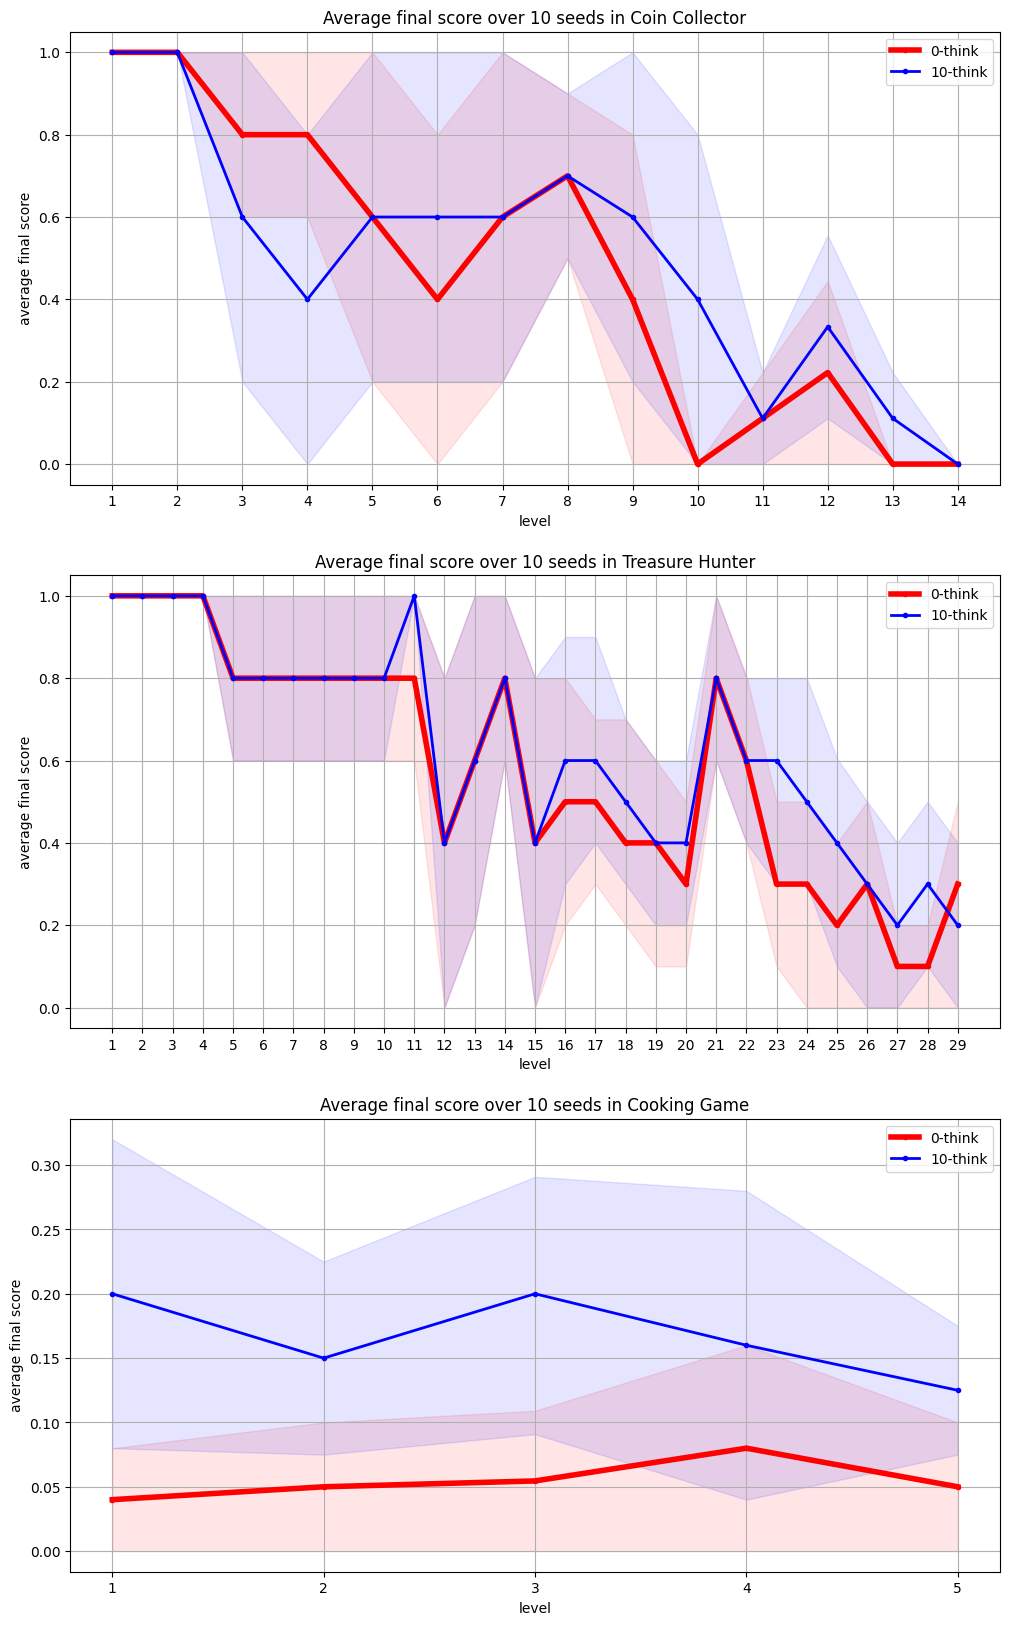

In [38]:
fig, axes = plt.subplots(3,1, figsize=figsize)
prettified_names = {"coin_collector": "Coin Collector", "treasure_hunter": "Treasure Hunter", "cooking": "Cooking Game"}

for i, game in enumerate(final_arrays.keys()):
    ax = axes[i]
    x = list(range(1, levels[game]+1))
    y_0, y_0_ci = final_arrays[game][0]
    y_10, y_10_ci = final_arrays[game][10]

    ax.plot(x, y_0, label="0-think", marker=".", linestyle="-", color="red", linewidth=4)
    ax.plot(x, y_10, label="10-think", marker=".", linestyle="-", color="blue", linewidth=2)

    ax.fill_between(x,
                    np.clip([i[0] for i in y_0_ci], 0, 1),
                    np.clip([i[1] for i in y_0_ci], 0, 1),
                    alpha=0.1, color="red")
    ax.fill_between(x,
                    np.clip([i[0] for i in y_10_ci], 0, 1),
                    np.clip([i[1] for i in y_10_ci], 0, 1),
                    alpha=0.1, color="blue")


    ax.set_title(f"Average final score over 10 seeds in {prettified_names[game]}")
    ax.set_xlabel('level')
    ax.set_ylabel('average final score')
    ax.legend()

    ax.set_xticks(x)
    # ax.set_ylim(ylims[game][0], ylims[game][1])
    ax.grid()

plt.show()